In [404]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Number of datasets
n = 1000

# Function creates the dataset based on desired number of inputs (base_set to 1000) and bus_size
def input_output_feature(num_buses, num_inputs):
    if num_buses < 2:
        raise ValueError("A power system must have at least 2 buses.")
        
    voltages_array = np.random.uniform(0.9, 1.1, size=(num_inputs, num_buses))

    # Repeat process for theta
    theta_array = np.random.uniform(0, np.pi/12, size=(num_inputs, num_buses))

    X = np.column_stack([voltages_array, theta_array])

    Y = np.zeros((num_inputs, num_buses * 2))
    for k in range(num_inputs):
        # Get the V and theta values for the CURRENT SAMPLE (k).
        V_k = voltages_array[k, :]   # V_k now holds [V_bus1, V_bus2, ..., V_busN] for sample k
        theta_k = theta_array[k, :] # theta_k holds [theta_bus1, ..., theta_busN] for sample k
        
        # Initialize an index to track where to place P and Q values in the current sample's output row.
        current_feature_idx = 0
        
        # Each bus's P and Q
        for i in range(num_buses):
            # Initialize sum for bus i
            P_i_total = 0.0
            Q_i_total = 0.0
            
            # Summation of bus i P and Q
            for j in range(num_buses):
                if i != j:  # Don't include self
                    V_i = V_k[i]
                    V_j = V_k[j]
                    theta_i = theta_k[i]
                    theta_j = theta_k[j]
                    
                    # Calculate P_ij and Q_ij (power flowing from i to j)
                    P_ij = V_i * V_j * np.cos(theta_i - theta_j)
                    Q_ij = V_i * V_j * np.sin(theta_i - theta_j)
                    
                    # Add to the total for bus i
                    P_i_total += P_ij
                    Q_i_total += Q_ij
            
            # Store the net P and Q for bus i
            Y[k, current_feature_idx] = P_i_total
            Y[k, current_feature_idx + 1] = Q_i_total
            
            # Move to next bus's P and Q positions
            current_feature_idx += 2

    return X, Y

In [405]:
# Split data into train/validation/test sets (train_test usually splits into 2 which is why 2 splits are necessary)
def prep(x,y):
    
    x_scaler = StandardScaler()
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    
    X_temp, X_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


    X_train = x_scaler.fit_transform(X_train)
    y_train = y_scaler.fit_transform(y_train)

    X_val = x_scaler.transform(X_val)
    y_val = y_scaler.transform(y_val)

    X_test = x_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)

    
    # Converting to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return [X_train, y_train, X_val, y_val, X_test, y_test]

In [406]:
# CNN network
class PowerFlowNN(nn.Module):
    def __init__(self, size, num_layer): # work on adjusting hidden_sizes
        super(PowerFlowNN, self).__init__()
        self.size = size
        input_size = size * 2   # 2 features per bus (P and Q)
        output_size = size * 2  # 2 outputs per bus (V and theta)
        
        # Scale hidden layers based on bus size
        hidden_sizes = []
        
        for i in range(num_layer):
            
            if i%3 == 0:
                hidden_sizes.append(int(size*2))
                
            elif i%3 == 1:
                hidden_sizes.append(int(size//2))
                
            else:
                hidden_sizes.append(int(size))
                
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size)) # connecting layers
            layers.append(nn.ReLU()) # learning patterns
            #layers.append(nn.Dropout(0.1)) # drops 10% of neurons to prevent overfitting (only for training data)(doesn't really work)
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

In [407]:
# Testing the CNN
def CNN_train_test(X_train, y_train, X_val, y_val, X_test, y_test, size, layer):
    total_train_loss = 0
    batch_size = 50
    epoch = 100
    train_loss_avg = 0
    val_cost_avg = 0
    best_cost = float('inf')
    best_params_state_dict = None # To save model state
    # defining CNN
    model = PowerFlowNN(size = size, num_layer = layer)
    # Define PyTorch optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss() 
    
    for m in range(epoch):
        model.train() # Set model to training mode
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad() # Zero the gradients before each batch
    
            # Get batch
            X_batch = X_train[i:min(i + batch_size, len(X_train))]
            y_batch = y_train[i:min(i + batch_size, len(y_train))]
    
            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
    
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
        model.eval() # Set model to evaluation mode for validation
        with torch.no_grad():
            val_predictions = model(X_val)
            curr_cost = criterion(val_predictions, y_val).item() # .item() to get Python number
    
        if curr_cost < best_cost:
            best_cost = curr_cost
            best_params_state_dict = model.state_dict() # Save the best model state
        train_loss_avg = loss.item()
        total_train_loss += loss.item()
        val_cost_avg = curr_cost
        if m % 10 == 0:
            #print(f"Epoch {m+1}, Train Loss: {train_loss_avg:.4f}, Val Cost: {val_cost_avg:.4f}")

            train_loss_avg = 0
            val_cost_avg = 0
    model.load_state_dict(best_params_state_dict)
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        test_cost = criterion(test_predictions, y_test).item() # .item() to get Python number
    #print(f'Test Loss: {test_cost}')
    return (total_train_loss/epoch, test_cost)
    # testing the data set

In [408]:
# Defining QNN with double angle embedding and measurement. Also includes a draw_circuit func so that the circuit can be drawn. 
class QuantumNeuralNetwork(nn.Module):
    def __init__(self, size, layers, compile_gates=None):
        super().__init__()
        self.size = size
        self.compile_gates = compile_gates
        
        # Create device inside class
        dev = qml.device('default.qubit', wires=size)
        
        @qml.qnode(dev, interface='torch')
        def circuit(inputs, weights):
            P_values = inputs[:, [i for i in range(0,size*2,2)]]
            Q_values = inputs[:, [i for i in range(1,size*2,2)]]
            qml.AngleEmbedding(features=P_values, wires=range(size), rotation='X')
            qml.AngleEmbedding(features=Q_values, wires=range(size), rotation='Y')
            
            qml.StronglyEntanglingLayers(weights, wires=range(size))
            
            measurements = []
            for i in range(size):
                measurements.append(qml.expval(qml.PauliX(i)))
                measurements.append(qml.expval(qml.PauliZ(i)))
            return measurements 

        # Compile the circuit if basis_set is provided
        if compile_gates:
            self.circuit = qml.compile(circuit, basis_set=compile_gates)
        else:
            self.circuit = circuit
        
        # Create TorchLayer from the (possibly compiled) circuit
        weight_shapes = {"weights": (layers, size, 3)}
        self.qnn = qml.qnn.TorchLayer(self.circuit, weight_shapes)
        self.layers = layers
        
    def draw_circuit(self):
        """Draw the quantum circuit with dummy data"""
        dummy_inputs = torch.randn(600, self.size * 2)        
        dummy_weights = torch.randn(self.layers, self.size, 3)
            
        print("Quantum Neural Network Circuit:")
        if self.compile_gates:
            print(f"Compiled to basis set: {self.compile_gates}")
        print("=" * 50)
        
        try:
            fig, ax = qml.draw_mpl(self.circuit)(dummy_inputs, dummy_weights)
            plt.show()
        except Exception as e:
            print(f"Error drawing circuit: {e}")
            dummy_inputs_np = dummy_inputs.detach().numpy()
            dummy_weights_np = dummy_weights.detach().numpy()
            circuit_drawing = qml.draw(self.circuit)(dummy_inputs_np, dummy_weights_np)
            print(circuit_drawing)

    def forward(self, x):
        return self.qnn(x)


In [409]:
# Testing the QNN
def QNN_train_test(X_train, y_train, X_val, y_val, X_test, y_test, size, layer):
    batch_size = 50
    epoch = 100
    total_train_loss = 0
    train_loss_avg = 0
    val_cost_avg = 0
    best_cost = float('inf')
    best_params_state_dict = None # To save model state
    # defining QNN
    model = QuantumNeuralNetwork(size = size, layers = layer)
    
    # Define PyTorch optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss() 
    
    for m in range(epoch):
        model.train() # Set model to training mode
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad() # Zero the gradients before each batch
    
            # Get batch
            X_batch = X_train[i:min(i + batch_size, len(X_train))]
            y_batch = y_train[i:min(i + batch_size, len(y_train))]
    
            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
    
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
        model.eval() # Set model to evaluation mode for validation
        with torch.no_grad():
            val_predictions = model(X_val)
            curr_cost = criterion(val_predictions, y_val).item() # .item() to get Python number
    
        if curr_cost < best_cost:
            best_cost = curr_cost
            best_params_state_dict = model.state_dict() # Save the best model state
        train_loss_avg = loss.item()
        total_train_loss += loss.item()
        val_cost_avg = curr_cost
        if m % 10 == 0:
            #print(f"Epoch {m+1}, Train Loss: {train_loss_avg:.4f}, Val Cost: {val_cost_avg:.4f}")

            train_loss_avg = 0
            val_cost_avg = 0
    model.load_state_dict(best_params_state_dict)
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        test_cost = criterion(test_predictions, y_test).item() # .item() to get Python number
    #print(f'Test Loss: {test_cost}')
    return (total_train_loss/epoch, test_cost)
    # testing the data set

In [410]:
#The following code allows you to pick the bus - size and based on that, the CNN and QNN are simulated in 3, 5 and 7 layers. The results are stored in a dictionary
bus_size = int(input('Pick bus-size: '))
CNN_QNN = {}
for a in range(3,8,2):
    for i in range(3,bus_size + 1):
        y_one, X_one = input_output_feature(i, n);
        data_one = prep(X_one,y_one);
        temp_CNN = CNN_train_test(data_one[0], data_one[1], data_one[2],data_one[3],data_one[4],data_one[5], size = i, layer = a); 
        temp_QNN = QNN_train_test(data_one[0], data_one[1], data_one[2],data_one[3],data_one[4],data_one[5], size = i, layer = a); 
        CNN_QNN[(a,i)] = {'CNN': temp_CNN, 'QNN': temp_QNN}

Pick bus-size:  7


In [411]:
# testing data per layer
layer_test_output = {3: {"CNN": [], "QNN": []}, 5: {"CNN": [], "QNN": []}, 7: {"CNN": [], "QNN": []} }

for key, value in CNN_QNN.items():
    layer_test_output[key[0]]["CNN"].append( value["CNN"][1]  )
    layer_test_output[key[0]]["QNN"].append( value["QNN"][1]  )

In [412]:
# training data per layer
layer_train_output = {3: {"CNN": [], "QNN": []}, 5: {"CNN": [], "QNN": []}, 7: {"CNN": [], "QNN": []} }

for key, value in CNN_QNN.items():
    layer_train_output[key[0]]["CNN"].append( value["CNN"][0]  )
    layer_train_output[key[0]]["QNN"].append( value["QNN"][0]  )

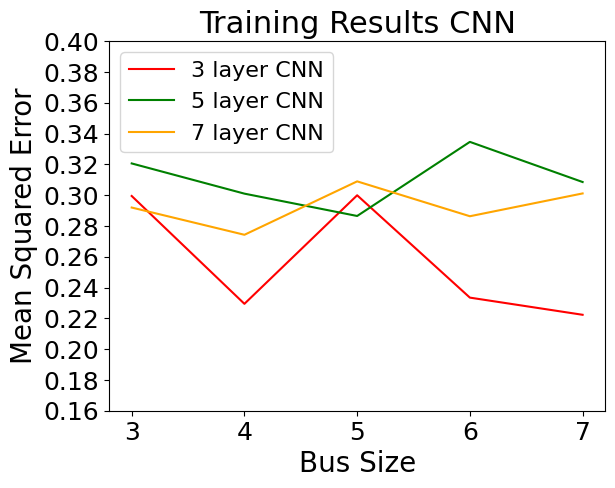

In [413]:
# Plotting the training results for the CNN
plt.plot([i for i in range(3, bus_size + 1)], layer_train_output[3]['CNN'], color = 'red', label = '3 layer CNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_train_output[5]['CNN'], color = 'green', label = '5 layer CNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_train_output[7]['CNN'], color = 'orange', label = '7 layer CNN');

plt.rcParams.update({
    'axes.labelsize': 20,     # x and y labels
    'axes.titlesize': 22,     # main title
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16
})
plt.legend();
plt.xticks([i for i in range(3, bus_size + 1)]);
plt.yticks([i/100 for i in range(16,41,2)]);
plt.xlabel('Bus Size');
plt.ylabel('Mean Squared Error');
plt.title('Training Results CNN');
plt.show();

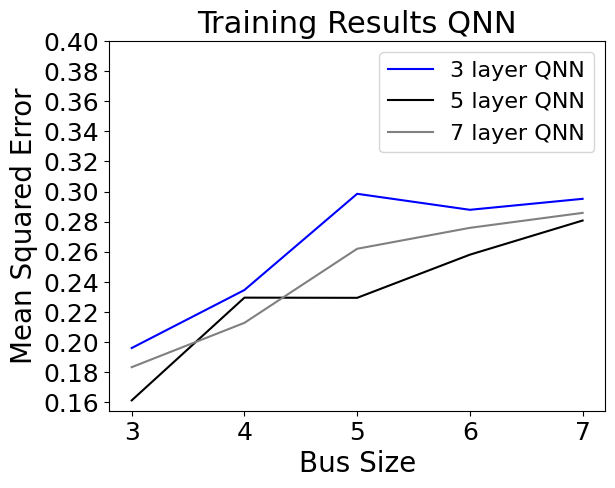

In [414]:
# Plotting the training results for the QNN
plt.plot([i for i in range(3, bus_size + 1)], layer_train_output[3]['QNN'], color = 'blue', label = '3 layer QNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_train_output[5]['QNN'], color = 'black', label = '5 layer QNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_train_output[7]['QNN'], color = 'grey', label = '7 layer QNN');
plt.rcParams.update({
    'axes.labelsize': 20,     # x and y labels
    'axes.titlesize': 22,     # main title
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16
})
plt.legend();
plt.xticks([i for i in range(3, bus_size + 1)]);
plt.yticks([i/100 for i in range(16,41,2)]);
plt.xlabel('Bus Size');
plt.ylabel('Mean Squared Error');
plt.title('Training Results QNN');

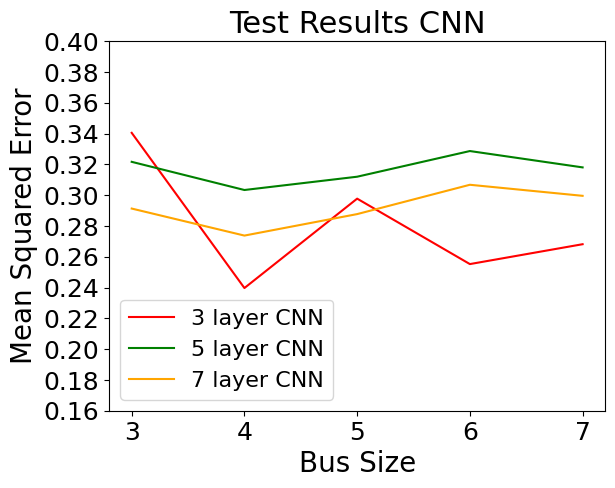

In [415]:
# Plotting the testing results for the CNN
plt.plot([i for i in range(3, bus_size + 1)], layer_test_output[3]['CNN'], color = 'red', label = '3 layer CNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_test_output[5]['CNN'], color = 'green', label = '5 layer CNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_test_output[7]['CNN'], color = 'orange', label = '7 layer CNN');

plt.rcParams.update({
    'axes.labelsize': 20,     # x and y labels
    'axes.titlesize': 22,     # main title
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16
})
plt.legend();
plt.xticks([i for i in range(3, bus_size + 1)]);
plt.yticks([i/100 for i in range(16,41,2)]);
plt.xlabel('Bus Size');
plt.ylabel('Mean Squared Error');
plt.title('Test Results CNN');
plt.show();


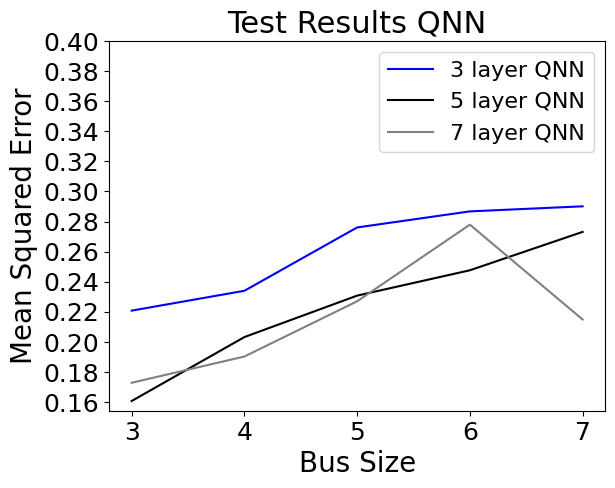

In [416]:
# Plotting the testing results for the QNN
plt.plot([i for i in range(3, bus_size + 1)], layer_test_output[3]['QNN'], color = 'blue', label = '3 layer QNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_test_output[5]['QNN'], color = 'black', label = '5 layer QNN');
plt.plot([i for i in range(3, bus_size + 1)], layer_test_output[7]['QNN'], color = 'grey', label = '7 layer QNN');

plt.rcParams.update({
    'axes.labelsize': 20,     # x and y labels
    'axes.titlesize': 22,     # main title
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16
})
plt.legend();
plt.xticks([i for i in range(3, bus_size + 1)]);
plt.yticks([i/100 for i in range(16,41,2)]);
plt.xlabel('Bus Size');
plt.ylabel('Mean Squared Error');
plt.title('Test Results QNN');
plt.show();

Quantum Neural Network Circuit:
Compiled to basis set: ['Hadamard', 'CNOT']


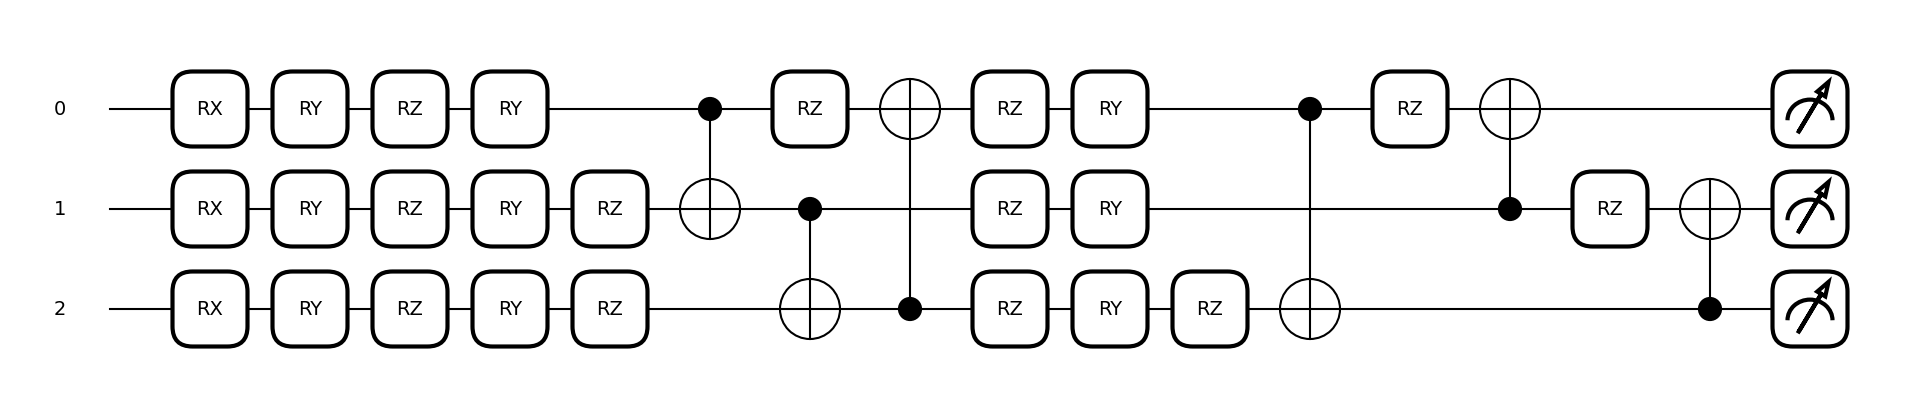

In [417]:
# Drawing the circuit for general reference

# Initiating QNN
qnn_minimal = QuantumNeuralNetwork(size=3, layers=2, compile_gates=['Hadamard', 'CNOT'])

# Draw circuits
qnn_minimal.draw_circuit()  # Shows compiled version



In [418]:
# Creating the final dataframe to store all of the data
CNN_QNN_df = pd.DataFrame.from_dict({'bus_size': [i for i in range(3,bus_size+1)], 
                                     'CNN_train_layer_3': layer_train_output[3]['CNN'],
                                     'CNN_train_layer_5': layer_train_output[5]['CNN'],
                                     'CNN_train_layer_7': layer_train_output[7]['CNN'],
                                     'CNN_test_layer_3': layer_test_output[3]['CNN'],
                                     'CNN_test_layer_5': layer_test_output[5]['CNN'],
                                     'CNN_test_layer_7': layer_test_output[7]['CNN'],
                                     'QNN_train_layer_3': layer_train_output[3]['QNN'],
                                     'QNN_train_layer_5': layer_train_output[5]['QNN'],
                                     'QNN_train_layer_7': layer_train_output[7]['QNN'],
                                     'QNN_test_layer_3': layer_test_output[3]['QNN'],
                                     'QNN_test_layer_5': layer_test_output[3]['QNN'],
                                     'QNN_test_layer_7': layer_test_output[3]['QNN']})

CNN_QNN_df
                                     


,bus_size,CNN_train_layer_3,CNN_train_layer_5,CNN_train_layer_7,CNN_test_layer_3,CNN_test_layer_5,CNN_test_layer_7,QNN_train_layer_3,QNN_train_layer_5,QNN_train_layer_7,QNN_test_layer_3,QNN_test_layer_5,QNN_test_layer_7
0,3,0.299434,0.320577,0.291939,0.340443,0.321620,0.291278,0.195976,0.161165,0.183251,0.220779,0.220779,0.220779
1,4,0.229411,0.300961,0.274248,0.239668,0.303323,0.273729,0.234539,0.229473,0.212722,0.233975,0.233975,0.233975
2,5,0.299898,0.286457,0.308932,0.297714,0.311956,0.287679,0.298500,0.229349,0.261958,0.276094,0.276094,0.276094
3,6,0.233441,0.334577,0.286288,0.255222,0.328624,0.306722,0.287865,0.258039,0.275875,0.286769,0.286769,0.286769
4,7,0.222296,0.308507,0.301099,0.268125,0.318005,0.299543,0.295161,0.280736,0.285824,0.290140,0.290140,0.290140


In [419]:
# Final results are that while QNN's start off better, CNN's end up generalizing better as the complexity of the system increases